# **Predicting Heart Disease: A Classification Analysis**
*Alvin de Vera, Peter Li, Vincent Luong, Wuyang Ren*

# Introduction
Our aim in data analysis is to build a classification model with high accuracy that can predict and classify whether a patient has heart disease. Using the re-processed data Cleveland Heart Disease from the UCI database, we will first observe the relationships between factors, such as age, cholesterol levels, and resting heart rate, with those that test positive for heart diseases. We will then use the strongest relationships to build our classification model.

# Method & Results

In [1]:
library(tidyverse)
library(repr)
library(rvest)
library(readxl)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ re

## Reading Data from the Web

In [2]:
url <- "https://raw.githubusercontent.com/aChipmunka/dsci100_2023s1_group21/main/project/data/heart_cleveland.csv"
cleveland_data <- read_csv(url)|>
                  mutate(condition = as_factor (condition)) 
head(cleveland_data)

Rows: 297 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
64,1,0,110,211,0,2,144,1,1.8,1,0,0,0
64,1,0,170,227,0,2,155,0,0.6,1,0,2,0


## Processing the Data

In [3]:
#Spliting the data into training and testing set
set.seed(2023)

cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = condition)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

#Creating a summary table
table_1 <- cleveland_train|>
         group_by (condition)|>
         summarize(average_age = mean(age), average_cholestoral = mean(chol))
table_1

age_disease_data <- cleveland_train|>
                    group_by(age)|>
                    filter(condition == 1)|>
                    summarize(count = n())

cholestoral_disease_data <- cleveland_train|>
                    group_by(chol)|>
                    filter(condition == 1)|>
                    summarize(count = n())

condition,average_age,average_cholestoral
<fct>,<dbl>,<dbl>
0,51.98333,243.0667
1,56.63725,251.1667


**Table 1**: This table shows that people with heart disease have a higher average age and cholesterol level. Therefore, age and cholesterol may be two variables that can help predict heart disease.

## Visualizations

`geom_smooth()` using formula 'y ~ x'



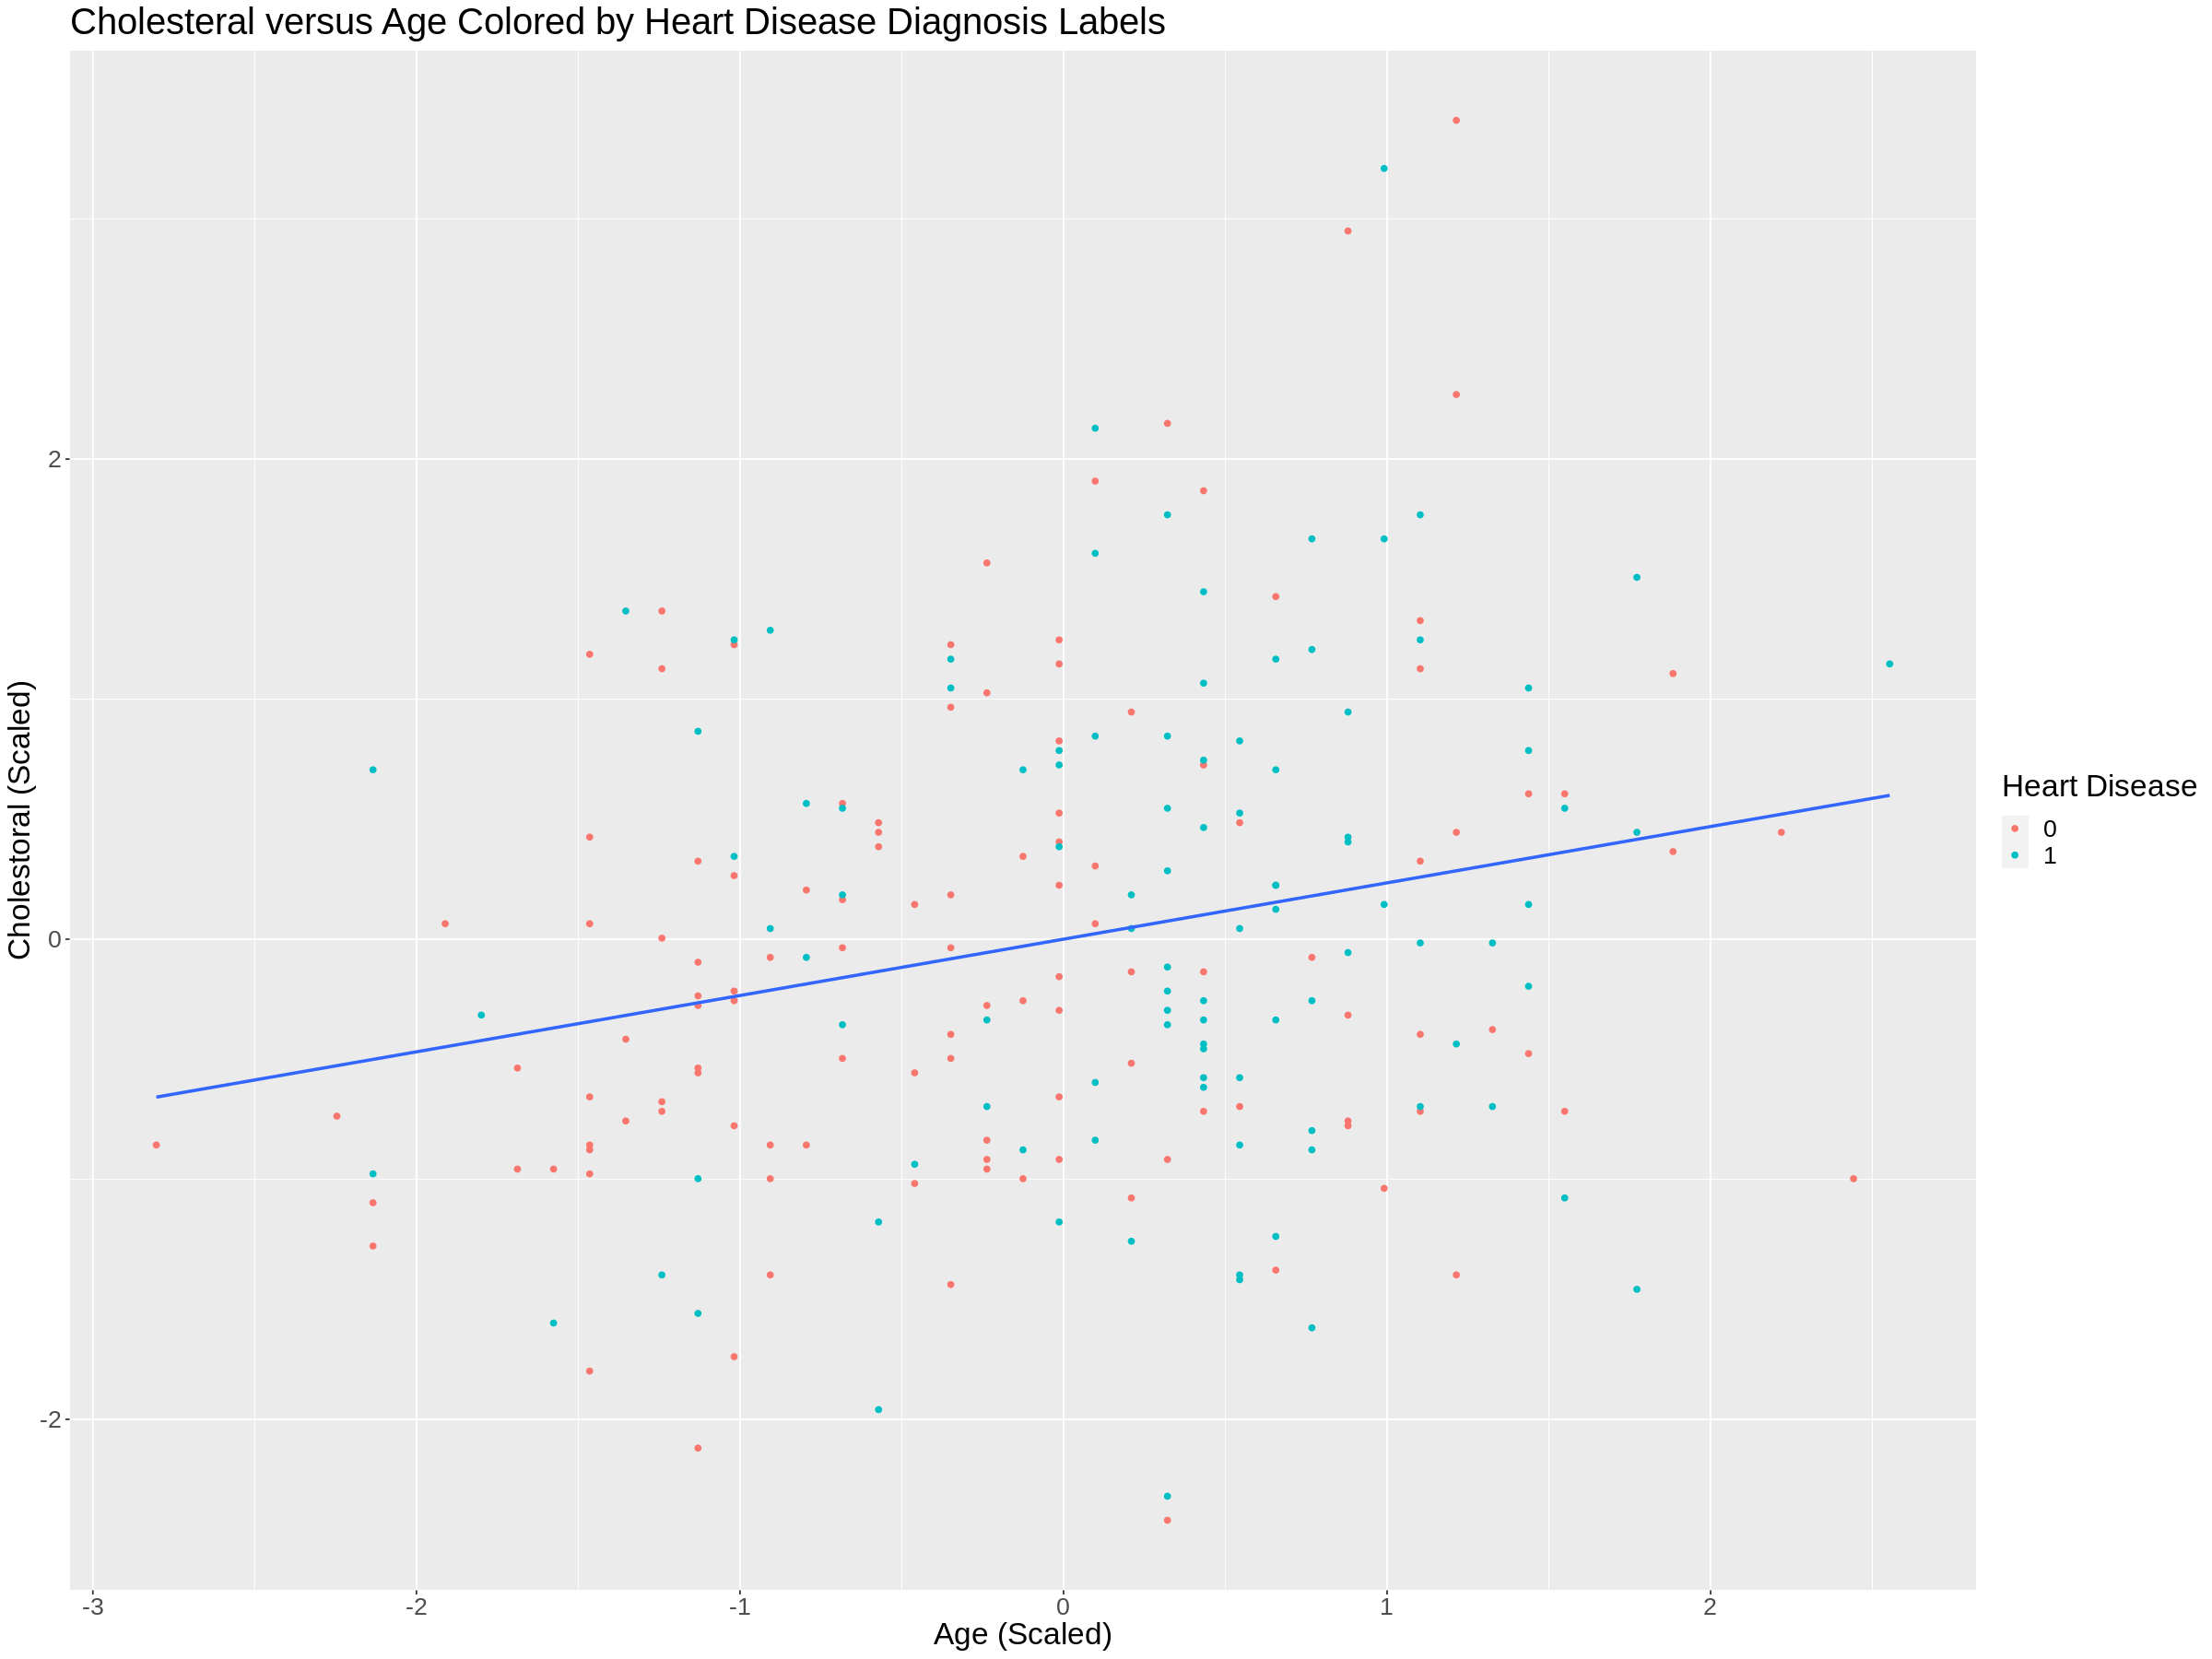

In [4]:
#Standardizing the variables
cleveland_recipe <- recipe(condition ~ age + chol, data = cleveland_train)|>
                    step_scale(all_predictors())|>
                    step_center(all_predictors())
cleveland_scaled <- cleveland_recipe|>
                    prep()|>
                    bake(cleveland_train)

#Creating a scatter plot
options(repr.plot.width=20, repr.plot.height=15)

age_cholestoral_disease_plot <- cleveland_scaled|> 
                  ggplot(aes(x= age, y= chol))+
                  geom_point(aes(color = condition))+
                  geom_smooth(method = "lm", se = FALSE)+
                  labs(x = "Age (Scaled)", y = "Cholestoral (Scaled)", color = "Heart Disease")+
                  theme(text = element_text(size = 20))+
                  ggtitle("Cholesteral versus Age Colored by Heart Disease Diagnosis Labels")
age_cholestoral_disease_plot

**Figure 1** :  Scatter plot of cholesterol level versus age colored by diagnosis label. As age increases, cholesterol level tends to be higher. By locating where the points for those with or without heart disease are located on the age - cholesterol coordinate, we can use these parameters to predict their diagnosis label.

## Cross-validation and choosing K

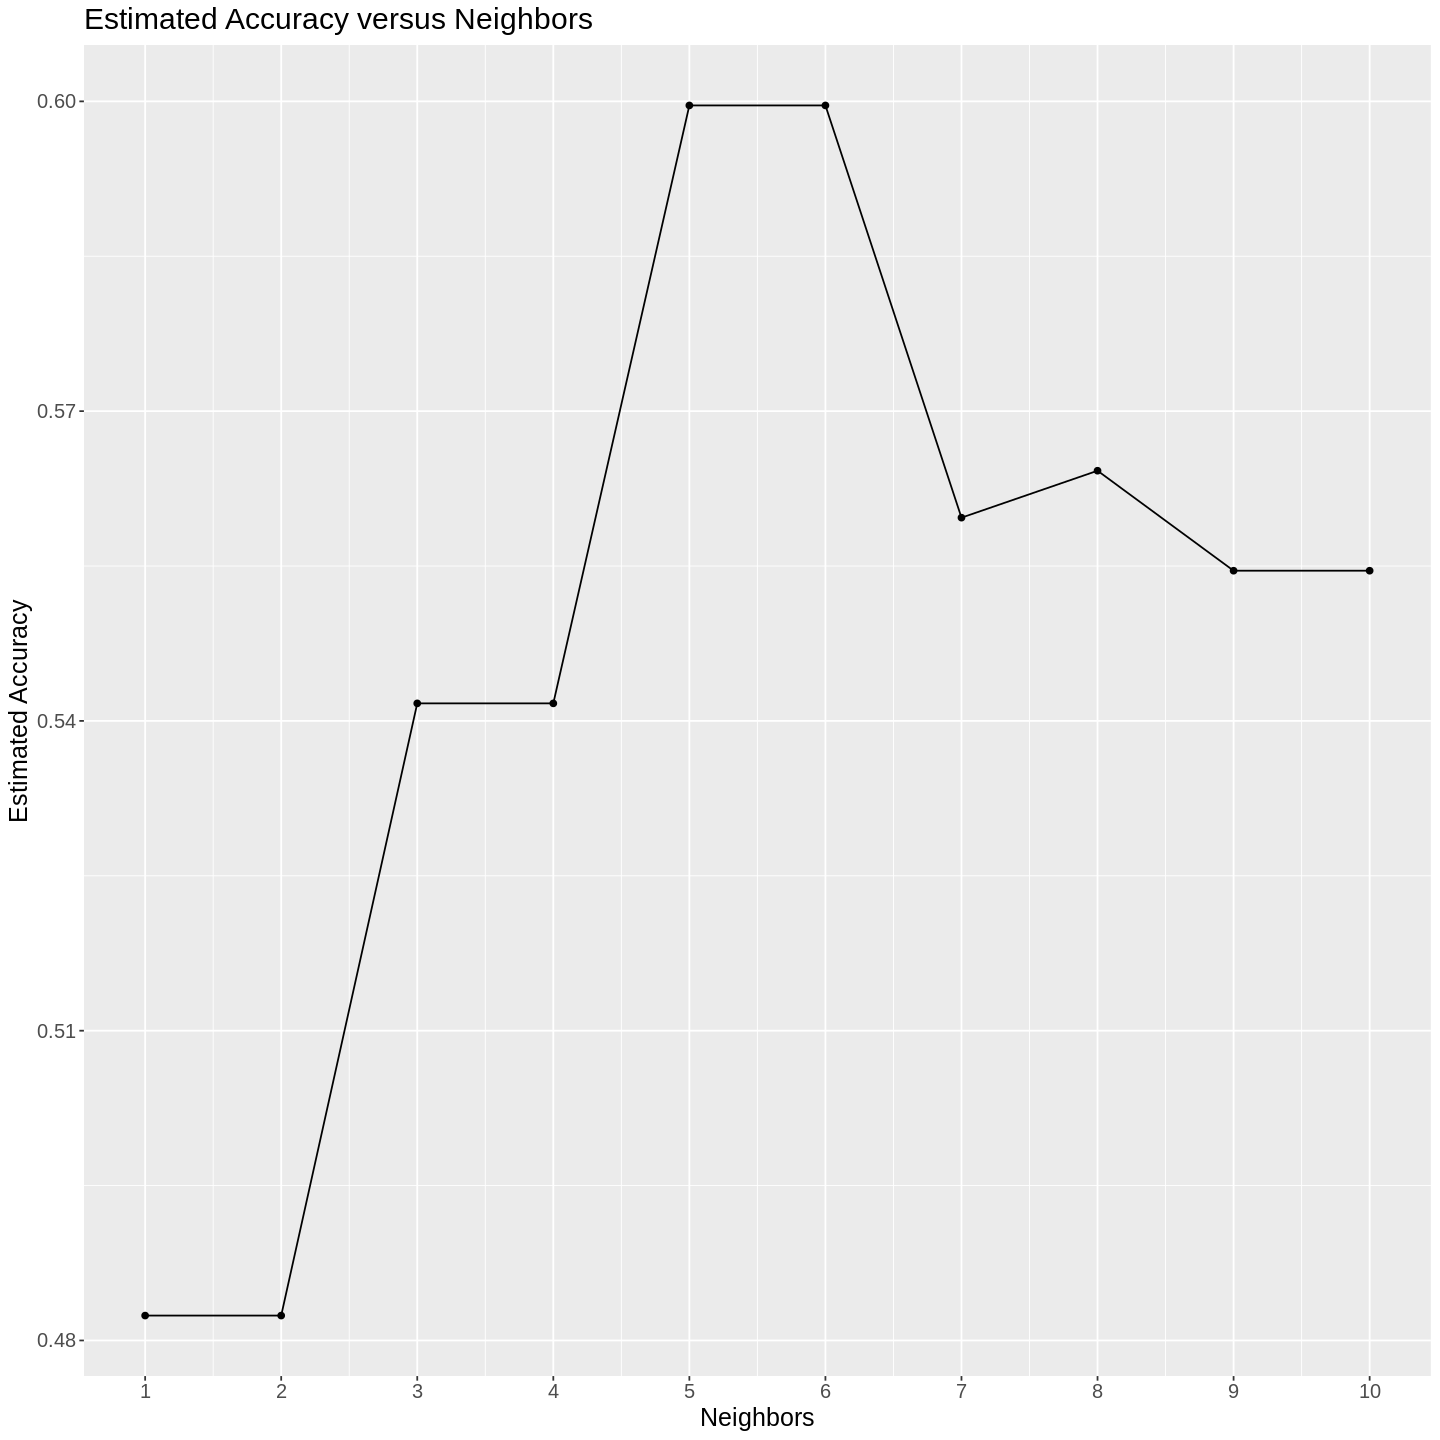

In [5]:
#Cross-validation
set.seed(2023)

gridvals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

cleveland_vfold <- vfold_cv(cleveland_train, v = 10, strata = condition)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
    set_engine("kknn")|>
    set_mode("classification")

knn_results <- workflow()|>
    add_recipe(cleveland_recipe)|>
    add_model(knn_tune)|>
    tune_grid(resamples = cleveland_vfold, grid = gridvals)|>
    collect_metrics()

#Creating plot of estimated accuracy vs neighbors
options(repr.plot.width=12, repr.plot.height=12)

accuracy_vs_k_plot <- knn_results|>
    filter(.metric == "accuracy")|>
    ggplot(aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "Estimated Accuracy")+
    scale_x_continuous(breaks = pull(gridvals))+
    ggtitle("Estimated Accuracy versus Neighbors")+
    theme(text = element_text(size = 15))

accuracy_vs_k_plot

**Figure 2**: Line plot of estimated accuracy versus neighbors. Estimated accuracy peaks first at k = 5, making it the best choice for number of neighbors to use.

## Building the Model

In [6]:
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
       set_engine("kknn") |>
       set_mode("classification")
heart_fit <- workflow() |>
             add_recipe(cleveland_recipe) |>
             add_model(heart_spec) |>
            fit(data = cleveland_train)
heart_predictions <- predict(heart_fit, cleveland_test) |>
                        bind_cols(cleveland_test)
heart_metrics <- heart_predictions |> 
                metrics(truth = condition, estimate = .pred_class)
heart_conf_mat <- heart_predictions |>
                        conf_mat(truth = condition, estimate = .pred_class) 
heart_metrics
heart_conf_mat
majority_test <- cleveland_data|>
                  group_by(condition)|>
                    summarize(count = n())
majority_test

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.53333333
kap,binary,0.06749556


          Truth
Prediction  0  1
         0 21 16
         1 19 19

condition,count
<fct>,<int>
0,160
1,137


## Finding better predictors (failed forward selection)

In [7]:

names <- colnames(cleveland_train |> select(-condition))
heart_formula <- paste("condition", "~", paste(names, collapse="+"))
heart_formula

[1] "condition ~ age+sex+cp+trestbps+chol+fbs+restecg+thalach+exang+oldpeak+slope+ca+thal"

In [8]:
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())



# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()


for (i in 1:n_total) {
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        preds_new <- c(selected, names[[j]])
        model_string <- paste("condition", "~", paste(preds_new, collapse="+"))
        heart_recipe <- recipe(as.formula(model_string), 
                                data = cleveland_train) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())
        acc <- workflow() |>
          add_recipe(heart_recipe) |>
          add_model(knn_tune |>
          tune_grid(resamples = cleveland_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
          acc <- acc$mx |> unlist()
          accs[[j]] <- acc
          models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

ERROR: Error in parse(text = x, srcfile = src): <text>:32:11: unexpected symbol
31:           summarize(mx = max(mean))
32:           acc
              ^


# Discussion